# Estudos de Modelagem Analítica


## Leitura e preprocessamento dos dados

Na primeira parte eu irei remover as colunas que não serão utilizadas e irei formatar a coluna de energia para que ela se tornar uma coluna com tipo de dados *float* 

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import scipy.special as special 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from sklearn.metrics import mean_absolute_percentage_error
from pandas import concat
from pandas import Series


plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
def changing_to_float(string): 
    try: 
        return float(string)
    except: 
        return float(string.replace('.','',1))

In [3]:
def format_data(series):
    series = series.apply(lambda x: changing_to_float(x))
    series = series.apply(lambda x: (x/10) if (x>20000) else x) ##retira alguns erros
    series = series.astype('float')
    return series

In [4]:
#load de data
df = pd.read_csv('2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv', 
                 parse_dates=['Data Escala de Tempo 1 GE Simp 4'], 
                 index_col='Data Escala de Tempo 1 GE Simp 4')

In [5]:
#removing some columns 
df = df.drop(columns=['Data Dica',
                 'dsc_estado', 
                 'id_subsistema', 
                 'nom_tipousinasite', 
                 'nom_usina2', 
                 'Período Exibido GE'])

In [6]:
df.rename(columns = {'Selecione Tipo de GE Simp 4':'energia'}, inplace = True)
df.index.names = ['data']
df = format_data(df.energia)

In [7]:
#saving the dataframe as csv
df.to_csv('timeserie_prepro.csv')

Na segunda parte do pre-processamento eu irei dividir definir a quantidade de dados que irei trabalhar para treinamento e para teste

In [8]:
#Split time series into a training/test
def split_to_train_test(series, test_percent=0.50):
    split_point = int(test_percent * len(series))
    return series[:-split_point], series[-split_point:]

In [9]:
#Select a percentage from the time series
def data_proportion(series, percent=1.0, end=True):
    if end: 
        series = series[-int(percent * len(series)):]
    else: 
        series = series[:int(percent * len(series))]
    return series

In [10]:
#load data
series = pd.read_csv('timeserie_prepro.csv', 
                  parse_dates=['data'], 
                  index_col='data',
                  squeeze=True)
print(f'Total data: {len(series)}')

Total data: 184782


In [11]:
series_per = data_proportion(series, percent=1)
print(f'Percentage data: {len(series_per)}')

Percentage data: 184782


In [12]:
#split data
train, test = split_to_train_test(series_per, test_percent=0.25)
print('Training %d, Teste %d' % (len(train), len(test)))

Training 138587, Teste 46195


In [13]:
train.to_csv('timeserie_train.csv')

In [14]:
test.to_csv('timeserie_test.csv')

## Analise exploratória dos dados

In [15]:
df = pd.read_csv('timeserie_train.csv',
                index_col='data', parse_dates=['data'],
                  squeeze=True)

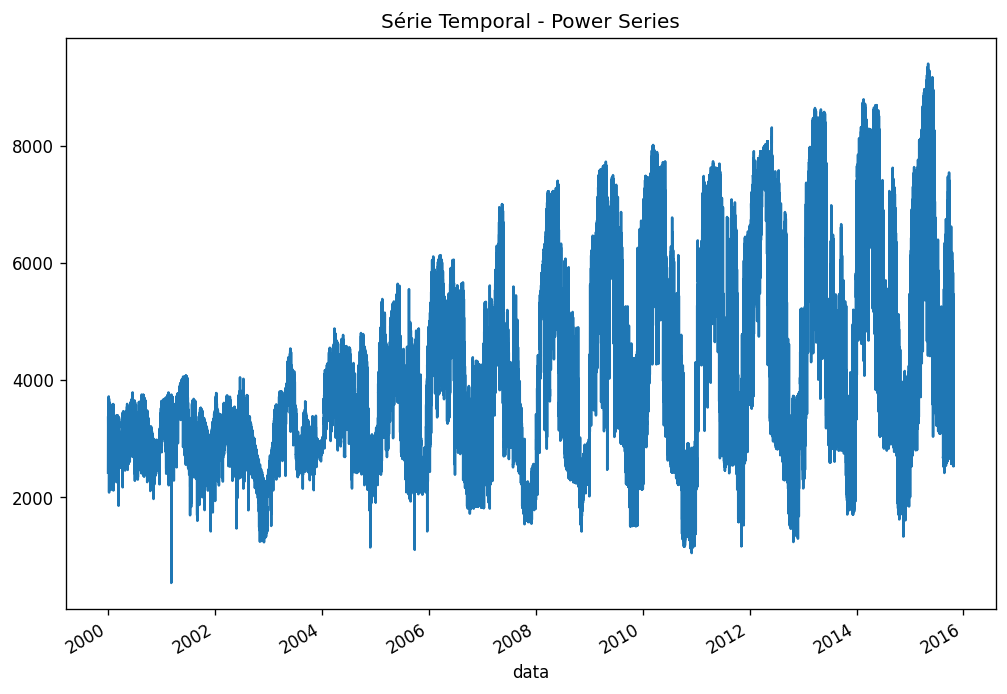

In [16]:
df.plot()
plt.title("Série Temporal - Power Series")
plt.show()

## Analise diária

In [17]:
def daily_plot(serie):
    groups = serie.groupby(pd.Grouper(freq='D'))
    values = list()
    days = list()
    for name, group in groups:
        df = pd.DataFrame(group.values)
        values.append(df)
        days.append(name.day)
    df = pd.concat(values, ignore_index=True, axis=1)
    df.columns = days
    df.plot(subplots=False, legend=True)
    plt.title("Daily Plot")
    plt.show()

Total of Date:692


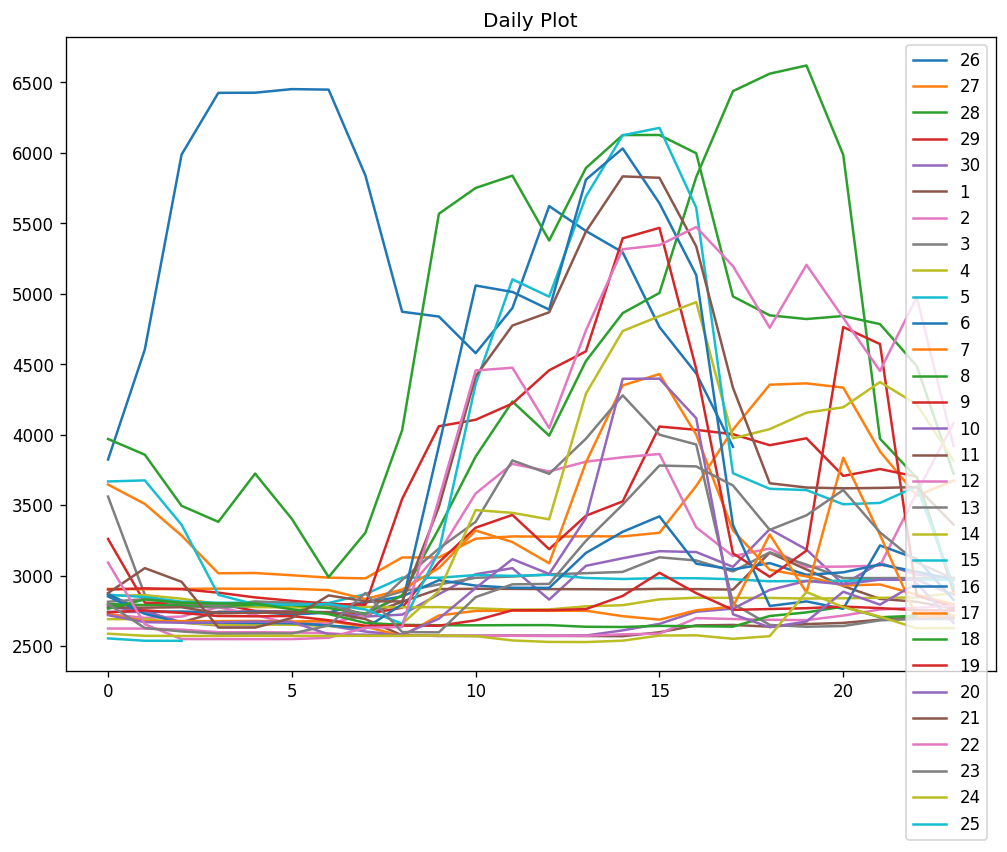

In [18]:
daily_data = data_proportion(df, percent=0.005, end=True)
print(f'Total of Date:{len(daily_data)}')
daily_plot(daily_data)

## Analise Semanal

In [19]:
def weekly_plot(serie):
    groups = serie.groupby(pd.Grouper(freq='W'))
    values = list()
    weeks = list()
    for name, group in groups:
        df = pd.DataFrame(group.values)
        values.append(df)
        weeks.append(name.week)
    df = pd.concat(values, ignore_index=True, axis=1)
    df.plot(subplots=False, legend=True)
    plt.title("Weekly Plot")
    plt.show()

Total of Date:1385


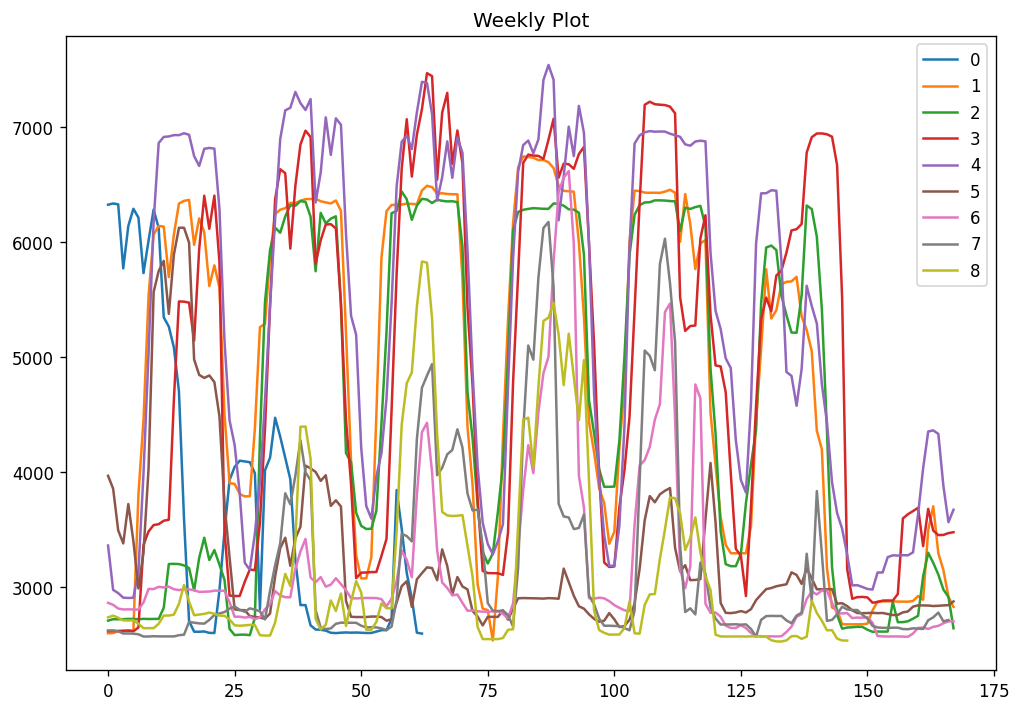

In [20]:
weekly_data = data_proportion(df, percent=0.01)
print(f'Total of Date:{len(weekly_data)}')
weekly_plot(weekly_data)

## Analise Mensal

In [21]:
def month_plot(serie):
    groups = serie[8:].groupby(pd.Grouper(freq='M'))
    values = list()
    months = list()
    for name, group in groups:
        df = pd.DataFrame(group.values)
        values.append(df)
        months.append(name.month)
    df = pd.concat(values, ignore_index=True, axis=1)
    df.columns = months
    df.plot(subplots=False, legend=True)
    plt.title("Monthly Plot")
    plt.show()

Total of Date:2771


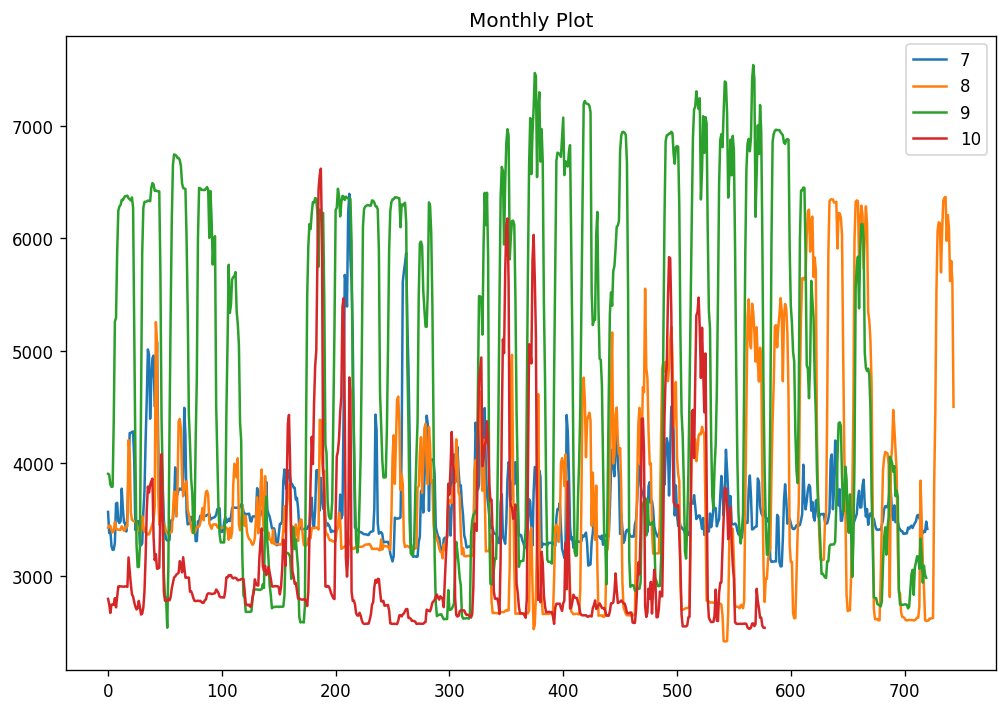

In [22]:
monthly_data = data_proportion(df, percent=0.02)
print(f'Total of Date:{len(monthly_data)}')
month_plot(monthly_data)

## Box Plot

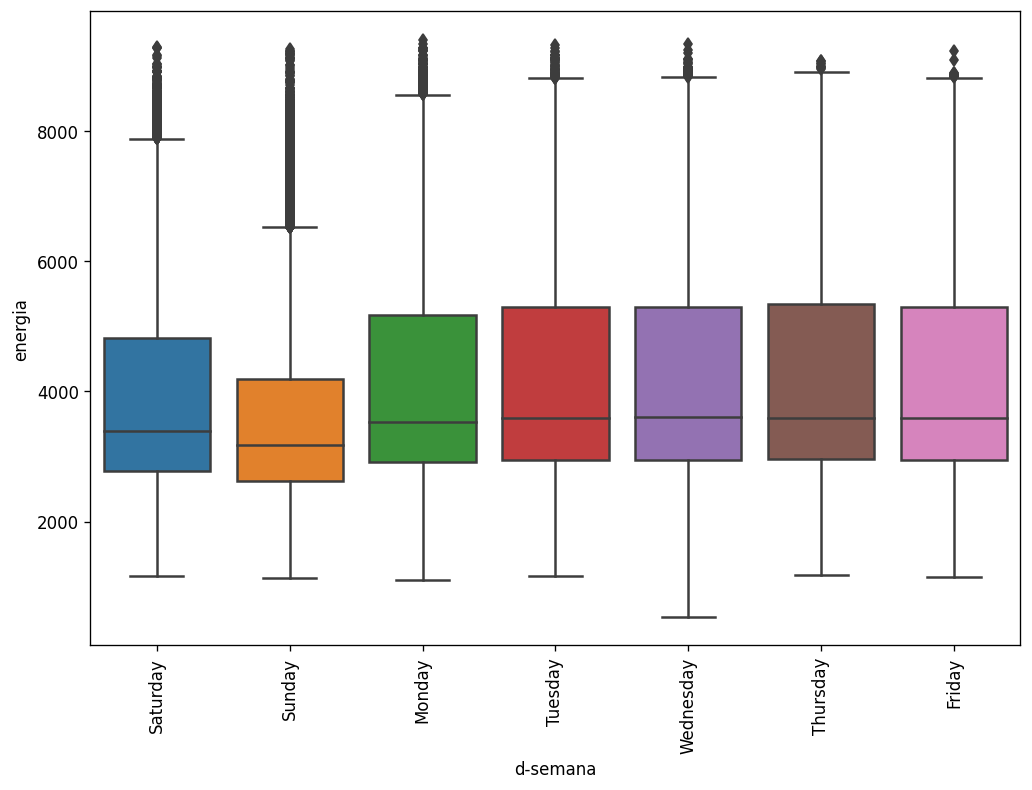

In [23]:
df = pd.read_csv('timeserie_train.csv',
                index_col='data', parse_dates=['data'])

df['d-semana'] = [d.strftime('%A') for d in df.index]

d = sns.boxplot(x='d-semana', y='energia', data=df)
d.set_xticklabels(d.get_xticklabels(),rotation=90)

plt.show()

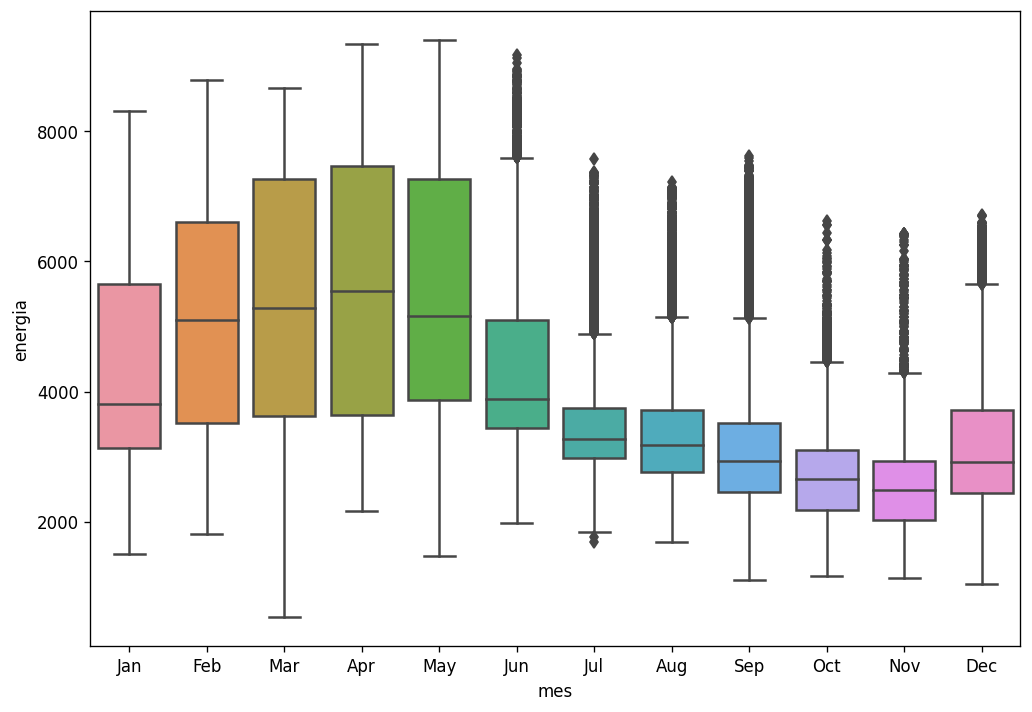

In [24]:
df['mes'] = [d.strftime('%b') for d in df.index]

sns.boxplot(x='mes', y='energia', data=df)

plt.show()

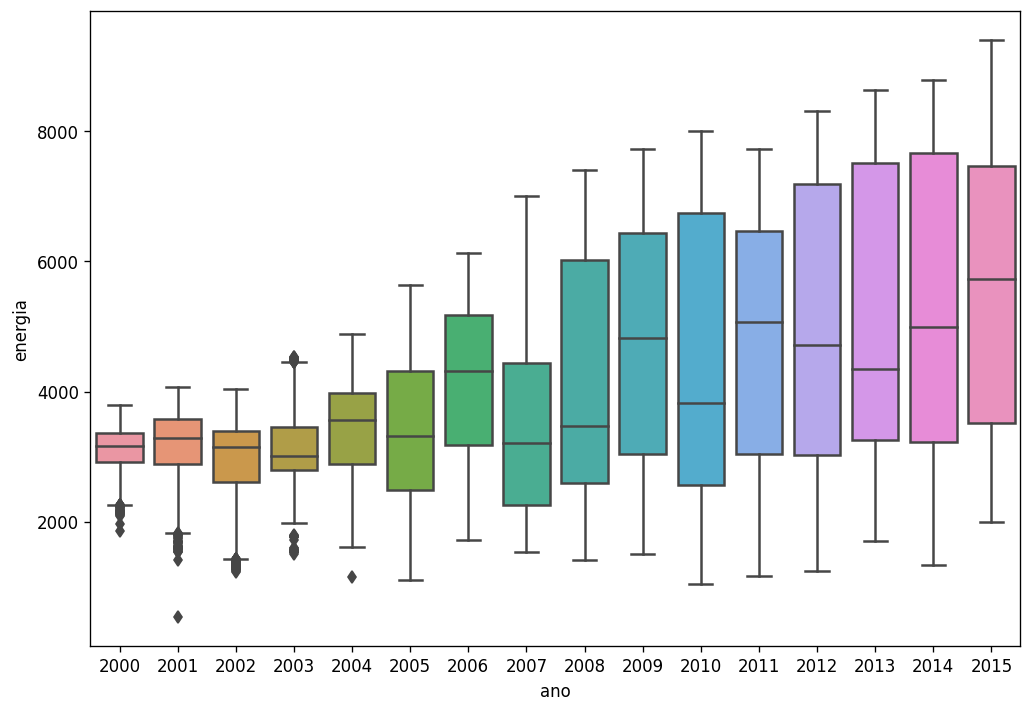

In [25]:
df['ano'] = [d.year for d in df.index]

sns.boxplot(x='ano', y='energia', data=df)

plt.show()

## Decomposição da Série

In [26]:
df = pd.read_csv('timeserie_train.csv',
                index_col='data', parse_dates=['data'])

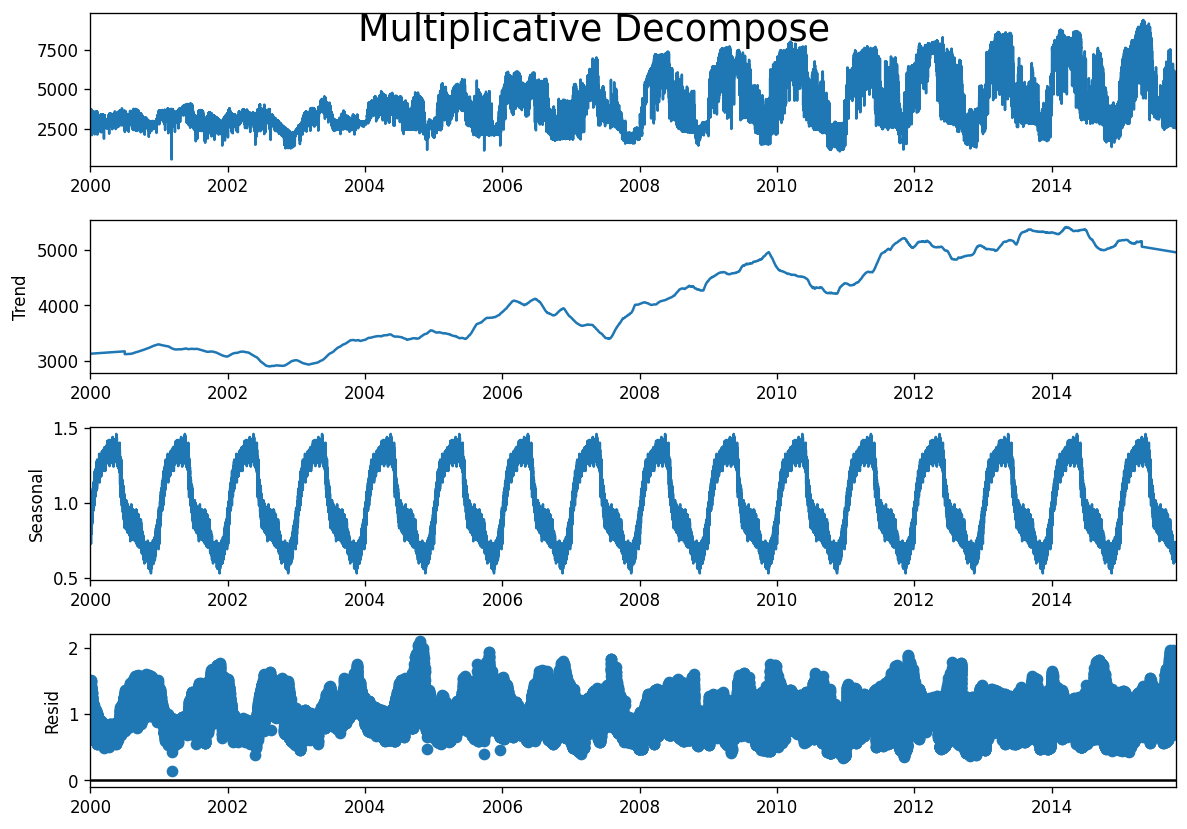

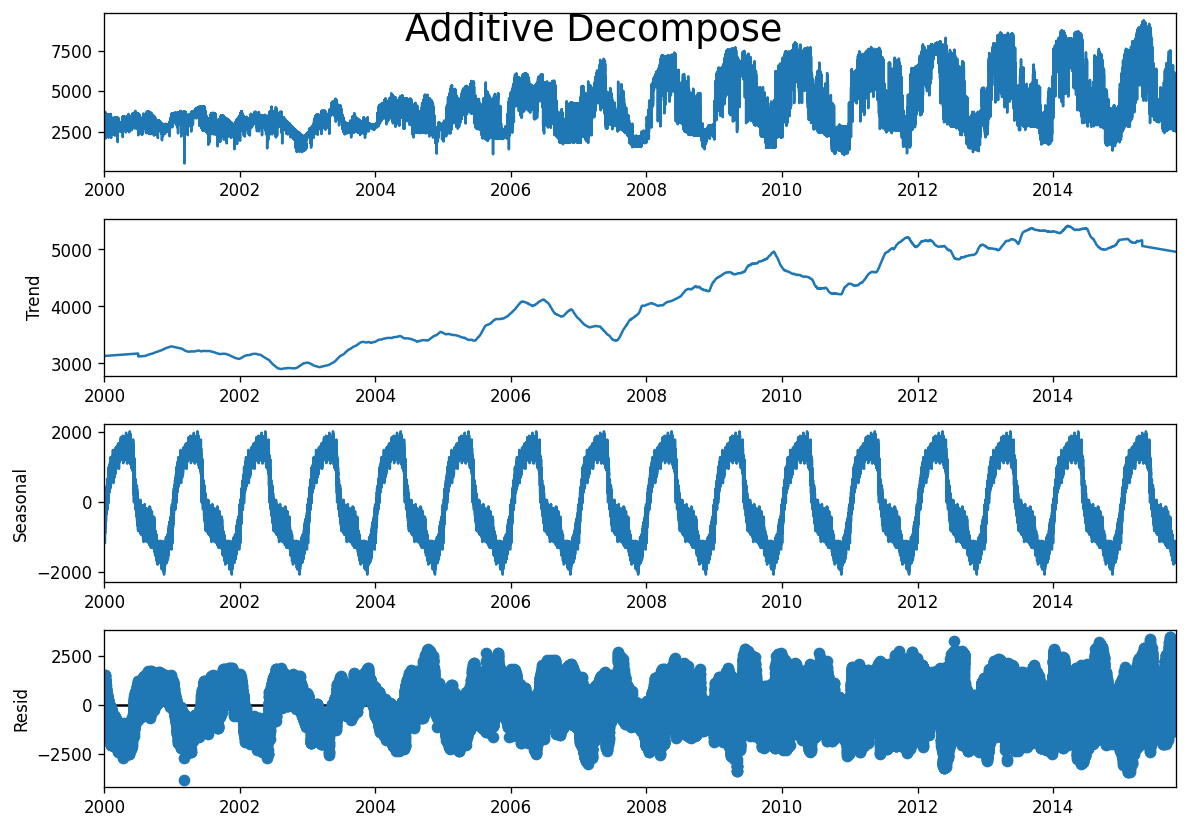

In [27]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model='multiplicative', period=365*24, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df, model='additive',period=365*24, extrapolate_trend='freq')

# Plot
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [28]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed_mul = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed_mul.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_mul.to_csv('timeserie_decom_mul_train.csv')
#df_reconstructed_mul.head()


In [29]:
# Actual Values = Sum of (Seasonal * Trend * Resid)
df_reconstructed_add = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed_add.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_add.to_csv('timeserie_decom_add_train.csv')
#df_reconstructed_add.head()

## Transformadas e Histogramas

In [30]:
df = pd.read_csv('timeserie_train.csv'
                 , parse_dates=['data']
                 , index_col='data', squeeze=True)

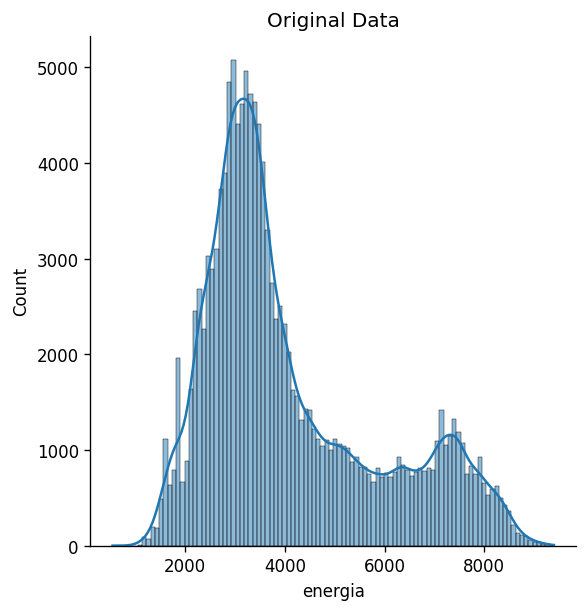

In [31]:
#sns.kdeplot(df, shade=True, label='data')
sns.displot(df, kde=True)
plt.title("Original Data")
plt.show()

### Transformada Ln

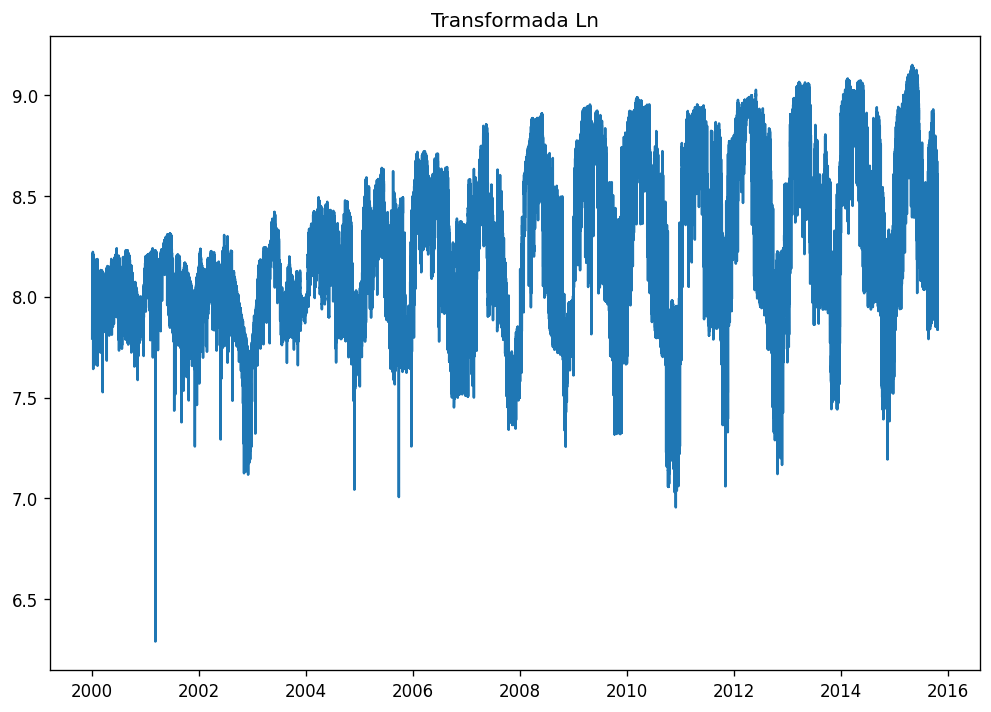

In [32]:
ts_log = np.log(df)
plt.title("Transformada Ln")
plt.plot(ts_log)
ts_log.to_csv('timeserie_log_train.csv')

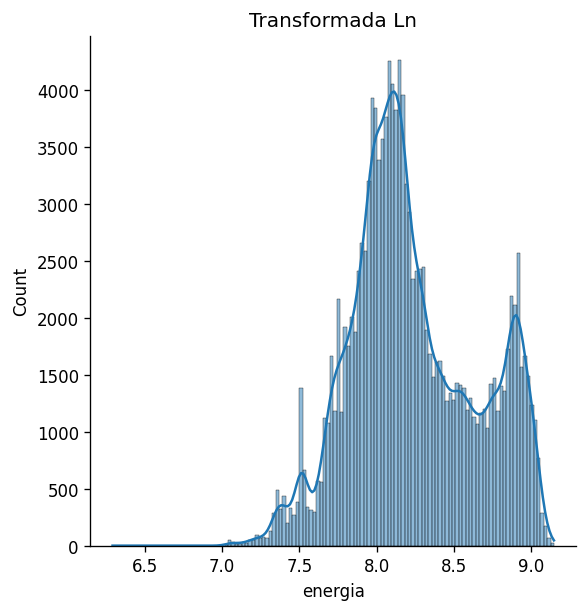

In [33]:
sns.displot(ts_log, kde=True)
plt.title("Transformada Ln")
plt.show()

### Transformada Box Cox

In [34]:
def boxcox_series(timeserie):
    fitted_data, fitted_lambda = stats.boxcox(timeserie) 
    box_cox = pd.concat([pd.DataFrame(timeserie.index),pd.DataFrame(fitted_data)],ignore_index=True,axis=1)
    box_cox.rename(columns = {0:'data' ,1:'energia'}, inplace = True)
    box_cox["lambda"] = fitted_lambda
    box_cox.reset_index(drop=True, inplace=True)
    box_cox = box_cox.set_index('data')
    return box_cox

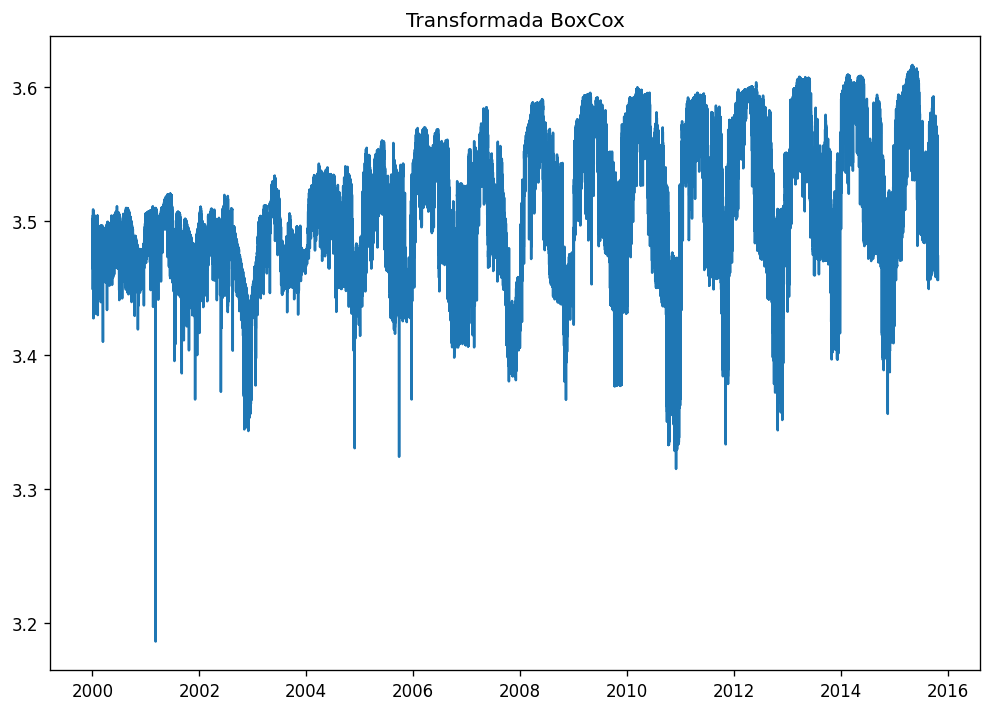

In [35]:
ts_box_cox = boxcox_series(df)
plt.title("Transformada BoxCox")
plt.plot(ts_box_cox.energia)

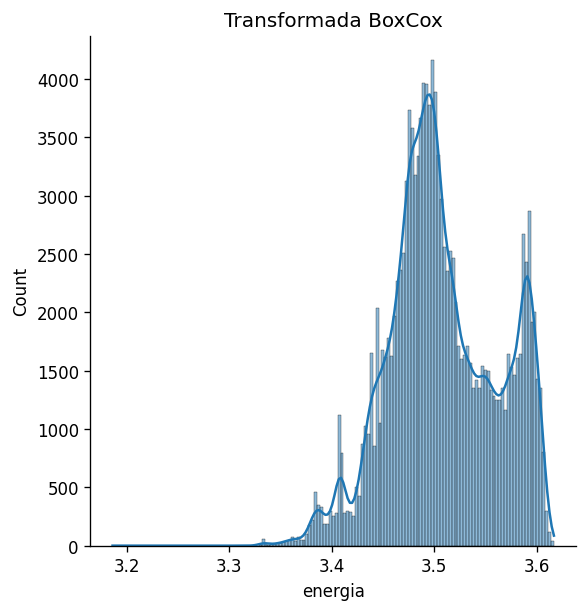

In [36]:
sns.displot(ts_box_cox.energia, kde=True)
plt.title("Transformada BoxCox")
plt.show()

## Média Movel

In [37]:
def rolling_mean(timeseries, title=""):
    #Determing rolling statistics
    rolmean = timeseries.rolling(24*365).mean()
    rolstd = timeseries.rolling(24*365).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    if title:
        plt.title('Rolling Mean & Standard Deviation: ' + title)
    else:
        plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


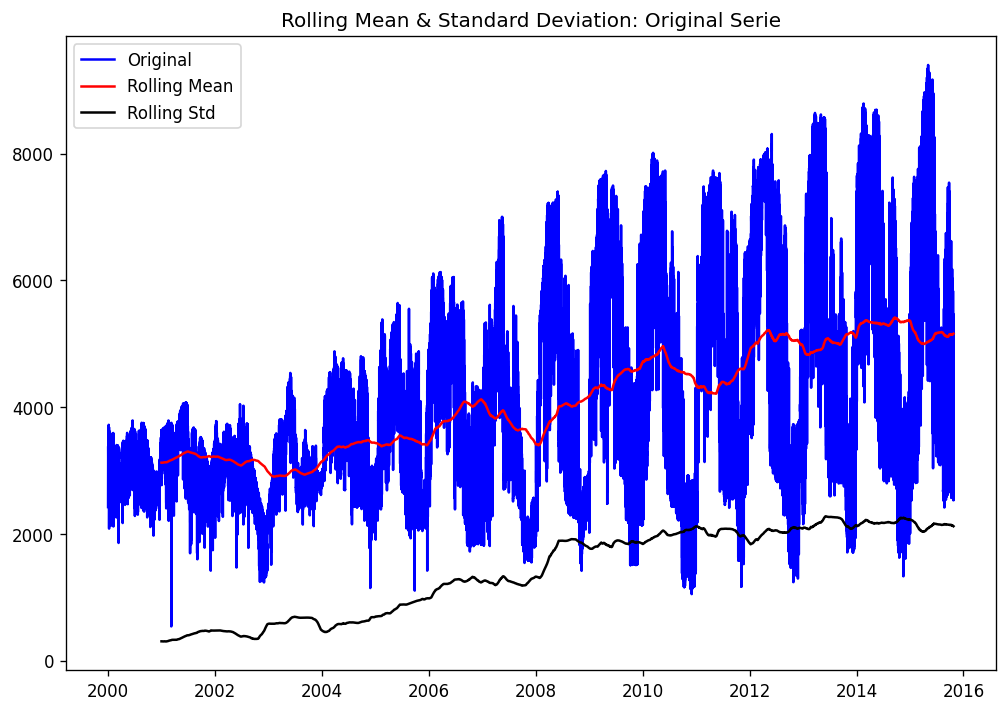

In [38]:
rolling_mean(df, "Original Serie")

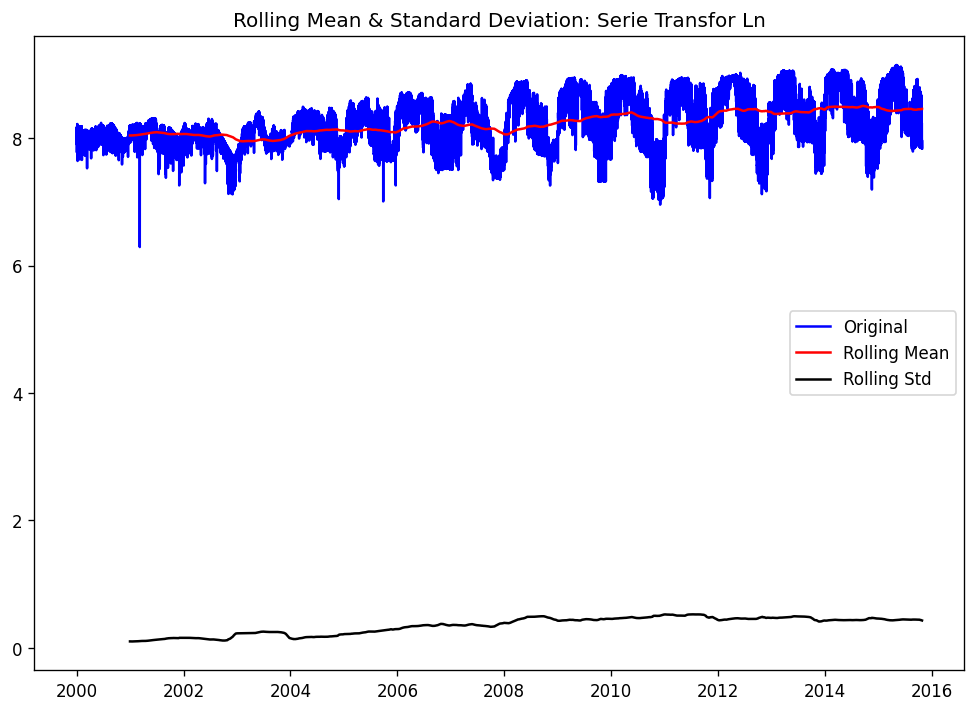

In [39]:
rolling_mean(ts_log, "Serie Transfor Ln")

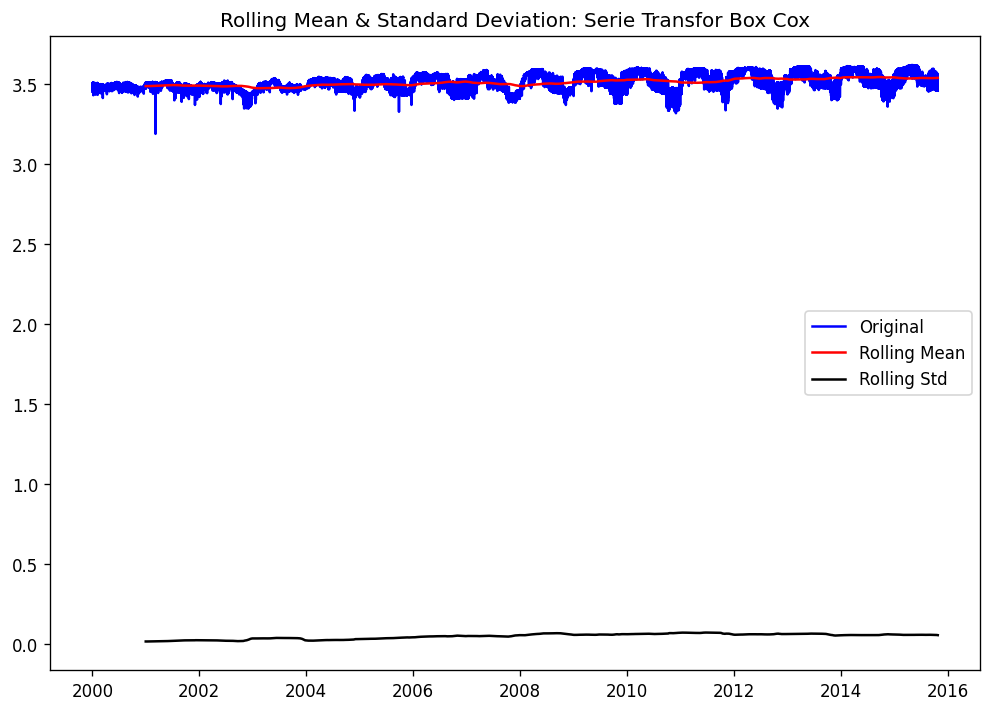

In [40]:
rolling_mean(ts_box_cox.energia, "Serie Transfor Box Cox")

## Testes de Estacionariedade

In [41]:
def ADF_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

In [42]:
def KPSS(timeseries):
    print('\nResults of KPSS Test:')
    result = kpss(timeseries, regression='c')
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

### Dados Originais

In [43]:
ADF_test(df)

Results of Dickey-Fuller Test:
ADF Statistic: -7.304257923981986
p-value: 1.3140785714926558e-10
Critial Values:
   1%, -3.430397211946923
Critial Values:
   5%, -2.8615608670048074
Critial Values:
   10%, -2.566781106765333


In [44]:
KPSS(df)


Results of KPSS Test:
KPSS Statistic: 41.487030
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [45]:
pp = PhillipsPerron(df)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -19.931
P-value                         0.000
Lags                               74
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Transformada Ln

In [46]:
ADF_test(ts_log)

Results of Dickey-Fuller Test:
ADF Statistic: -7.980696564187971
p-value: 2.6282941883205174e-12
Critial Values:
   1%, -3.430397211606068
Critial Values:
   5%, -2.8615608668541554
Critial Values:
   10%, -2.5667811066851463


In [47]:
KPSS(ts_log)


Results of KPSS Test:
KPSS Statistic: 32.058286
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [48]:
pp = PhillipsPerron(ts_log)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.377
P-value                         0.000
Lags                               74
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Transformada Box-Cox 

In [49]:
ADF_test(ts_box_cox.energia)

Results of Dickey-Fuller Test:
ADF Statistic: -8.23189856258532
p-value: 6.031575561133455e-13
Critial Values:
   1%, -3.430397211606068
Critial Values:
   5%, -2.8615608668541554
Critial Values:
   10%, -2.5667811066851463


In [50]:
KPSS(ts_box_cox.energia)


Results of KPSS Test:
KPSS Statistic: 29.075053
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [51]:
pp = PhillipsPerron(ts_box_cox.energia)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -24.773
P-value                         0.000
Lags                               74
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Previsões

### Dados Originais

In [53]:
# Load data
train = pd.read_csv('timeserie_train.csv',
                     header=0, index_col=0, parse_dates=True, squeeze=True)
test = pd.read_csv('timeserie_test.csv',
                     header=0, index_col=0, parse_dates=True, squeeze=True)

#### Persistence One Step

In [54]:
def persistence_one_step(train, test, show_results=False, plot_result=False):
    # Prepare data
    test = test.values
    train = [x for x in train]
    
    # Walk-forward validation
    predictions = list()
    
    for i in range(len(test)):
        # Predict
        yhat = train[-1]
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
        
    # Report performance
    mape = mean_absolute_percentage_error(test, predictions)
    print('MAPE: %.3f' % mape)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.show()


In [56]:
persistence_one_step(train, test)

MAPE: 0.046


### Persistence multi step

In [57]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    plt.plot(series)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]  
        plt.plot(xaxis, yaxis, color='red')
    # Show the final plot
    plt.show()  

In [58]:
def persistence_multi_step(train,test, steps=24, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([train, test], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train = [x for x in train]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train[-1]
        yhat = persistence(last_ob, n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
    # Evaluate the forecasts
    evaluate_forecasts(test, forecasts, n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts(series, forecasts, test)


In [59]:
# Evaluate the MAPE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print('t+%d MAPE: %f' % ((i+1), (mean_absolute_percentage_error(ytrue_ts, ypred_ts))))

In [60]:
# Make a multi-step persistence forecast
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


In [61]:
persistence_multi_step(train, test, steps=24, plot_result=False)

t+1 MAPE: 0.046175
t+2 MAPE: 0.083175
t+3 MAPE: 0.113995
t+4 MAPE: 0.141446
t+5 MAPE: 0.165755
t+6 MAPE: 0.187128
t+7 MAPE: 0.204941
t+8 MAPE: 0.219083
t+9 MAPE: 0.229940
t+10 MAPE: 0.237757
t+11 MAPE: 0.243091
t+12 MAPE: 0.246555
t+13 MAPE: 0.248109
t+14 MAPE: 0.247805
t+15 MAPE: 0.245368
t+16 MAPE: 0.239942
t+17 MAPE: 0.231268
t+18 MAPE: 0.219475
t+19 MAPE: 0.204962
t+20 MAPE: 0.189307
t+21 MAPE: 0.173514
t+22 MAPE: 0.158382
t+23 MAPE: 0.144943
t+24 MAPE: 0.138450


### Transformada Ln

In [62]:
train_log = np.log(train)
teste_log = np.log(test)

#### Persistence One Step

In [63]:
def persistence_one_step_ln(train_log, teste_log, 
    show_results=False, plot_result=False):
    # Prepare data
    teste_log = teste_log.values
    train_log = [x for x in train_log]

    # Walk-forward validation
    predictions = list()

    for i in range(len(teste_log)):
        # Predict
        yhat = train_log[-1]
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to train for the next loop
        obs = teste_log[i]
        train_log.append(obs)
        
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


    # Report performance
    mape = mean_absolute_percentage_error(np.exp(teste_log), np.exp(predictions))
    print('MAPE: %.3f' % mape)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(np.exp(teste_log))
        plt.plot(np.exp(predictions), color='red')
        plt.show()

In [64]:
persistence_one_step_ln(train_log, teste_log)

MAPE: 0.046


#### Persistence Multi Step

In [69]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts_ln(series, forecasts, test):
    # Plot the entire dataset in blue
    plt.plot(np.exp(series))
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        plt.plot(xaxis, np.exp(yaxis), color='red')
    # Show the final plot
    plt.show()   

In [70]:
# Evaluate the MAPE for each forecast time step
def evaluate_forecasts_ln(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print('t+%d MAPE: %f' % ((i+1), (mean_absolute_percentage_error(ytrue_ts, ypred_ts))))

In [71]:
def persistence_multi_step_ln(train,test, steps=24, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([train, test], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train = [x for x in train]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train[-1]
        yhat = persistence(last_ob, n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
    # Evaluate the forecasts
    evaluate_forecasts_ln(np.exp(test), np.exp(forecasts), n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts_ln(series, forecasts, test)

In [74]:
persistence_multi_step_ln(train_log, teste_log, steps=24, plot_result=False)

t+1 MAPE: 0.046175
t+2 MAPE: 0.083175
t+3 MAPE: 0.113995
t+4 MAPE: 0.141446
t+5 MAPE: 0.165755
t+6 MAPE: 0.187128
t+7 MAPE: 0.204941
t+8 MAPE: 0.219083
t+9 MAPE: 0.229940
t+10 MAPE: 0.237757
t+11 MAPE: 0.243091
t+12 MAPE: 0.246555
t+13 MAPE: 0.248109
t+14 MAPE: 0.247805
t+15 MAPE: 0.245368
t+16 MAPE: 0.239942
t+17 MAPE: 0.231268
t+18 MAPE: 0.219475
t+19 MAPE: 0.204962
t+20 MAPE: 0.189307
t+21 MAPE: 0.173514
t+22 MAPE: 0.158382
t+23 MAPE: 0.144943
t+24 MAPE: 0.138450


### Transformada Box-Cox

In [97]:
ts_box_cox = boxcox_series(series_per)


In [98]:
train_box_cox, test_box_cox = split_to_train_test(ts_box_cox, test_percent=0.25)

#### Persistence One Step

In [99]:
def persistence_one_step_box_cox(train_box_cox, test_box_cox, 
    show_results=False, plot_result=False):
    # Prepare data
    lbda = train_box_cox["lambda"][0]
    test_box_cox = test_box_cox.energia.values
    train_box_cox = [x for x in train_box_cox.energia]

    # Walk-forward validation
    predictions = list()

    for i in range(len(test_box_cox)):
        # Predict
        yhat = train_box_cox[-1]
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to train for the next loop
        obs = test_box_cox[i]
        train_box_cox.append(obs)
        
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

    # Report performance
    test = special.inv_boxcox(test_box_cox, lbda)
    pred = special.inv_boxcox(predictions, lbda)
    mape = mean_absolute_percentage_error(test, pred)
    print('MAPE: %.3f' % mape)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(special.inv_boxcox(test_box_cox, lbda))
        plt.plot(special.inv_boxcox(predictions, lbda), color='red')
        plt.show()



In [100]:
persistence_one_step_box_cox(train_box_cox, test_box_cox)

MAPE: 0.046


#### Persistence Multi Step

In [107]:
def plot_forecasts_box_cox(series, forecasts, test, lbda):
    # Plot the entire dataset in blue
    plt.plot(special.inv_boxcox(series, lbda))
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]  
        plt.plot(xaxis, special.inv_boxcox(yaxis, lbda), color='red')
    # Show the final plot
    plt.show()  

In [108]:
# Evaluate the MAPE for each forecast time step
def evaluate_forecasts_box_cox(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print('t+%d MAPE: %f' % ((i+1), (mean_absolute_percentage_error(ytrue_ts, ypred_ts))))


In [109]:
def persistence_multi_step_box_cox(train,test, steps=24, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([train.energia, test.energia], axis=0)
    # Prepare data
    lbda = train["lambda"][0]
    test = test.energia.values
    series = series.values
    train = [x for x in train.energia]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train[-1]
        yhat = persistence(last_ob, n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
    # Evaluate the forecasts
    evaluate_forecasts_box_cox(special.inv_boxcox(test, lbda), 
        special.inv_boxcox(forecasts, lbda), n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts_box_cox(series, forecasts, test, lbda)


In [111]:
persistence_multi_step_box_cox(train_box_cox, test_box_cox, steps=24, plot_result=False)

t+1 MAPE: 0.046175
t+2 MAPE: 0.083175
t+3 MAPE: 0.113995
t+4 MAPE: 0.141446
t+5 MAPE: 0.165755
t+6 MAPE: 0.187128
t+7 MAPE: 0.204941
t+8 MAPE: 0.219083
t+9 MAPE: 0.229940
t+10 MAPE: 0.237757
t+11 MAPE: 0.243091
t+12 MAPE: 0.246555
t+13 MAPE: 0.248109
t+14 MAPE: 0.247805
t+15 MAPE: 0.245368
t+16 MAPE: 0.239942
t+17 MAPE: 0.231268
t+18 MAPE: 0.219475
t+19 MAPE: 0.204962
t+20 MAPE: 0.189307
t+21 MAPE: 0.173514
t+22 MAPE: 0.158382
t+23 MAPE: 0.144943
t+24 MAPE: 0.138450


## Difference

In [112]:
# difference a series
def difference(train):
    diff = list()
    # lose first value
    for i in range(1, len(train)):
        # substract the current value and its prior value 
        value = train[i] - train[i - 1]
        diff.append(value)
    diff = Series(diff)
    diff.index = train.index[1:]
    return diff

In [113]:
# invert a differenced series 
def invert_difference(train, diff):
    series = []
    # add first value
    series.append(train[0])
    for idx in range(len(diff)):
        # sum the current value and its prior value 
        series.append(diff[idx] + train[idx])
    series = Series(series)
    series.index = train.index
    return series

In [114]:
ts_diff_train = difference(train)
ts_diff_test = difference(test)

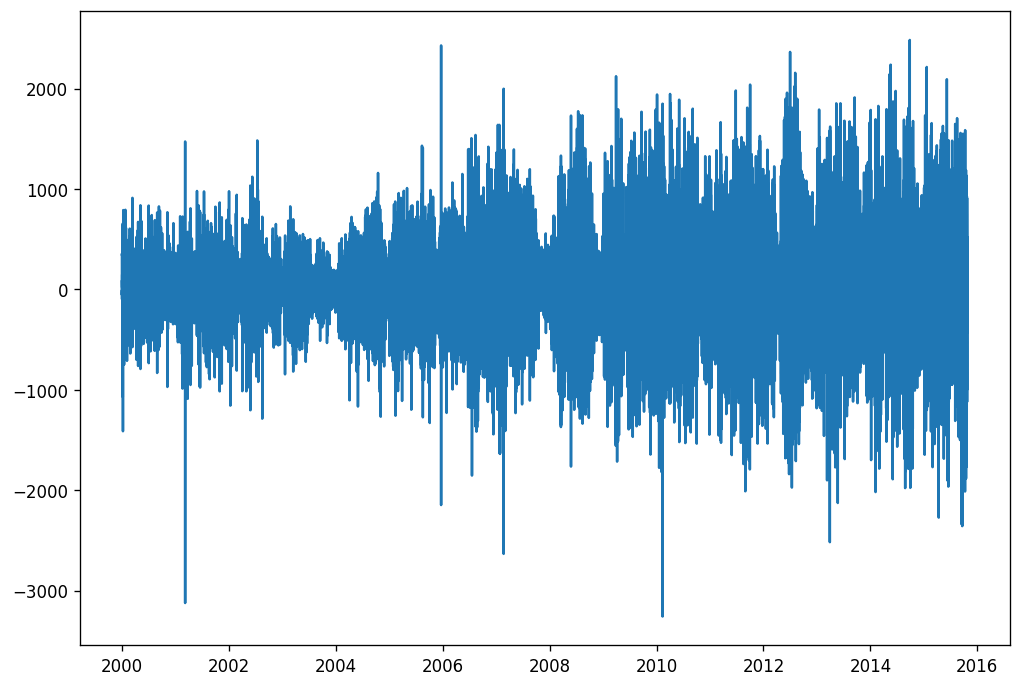

In [115]:
plt.plot(ts_diff_train)
plt.show()

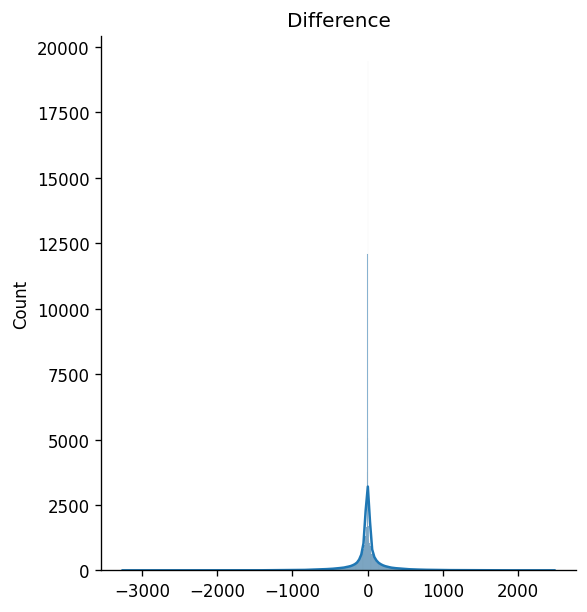

In [116]:
sns.displot(ts_diff_train, kde=True)
plt.title("Difference")
plt.show()

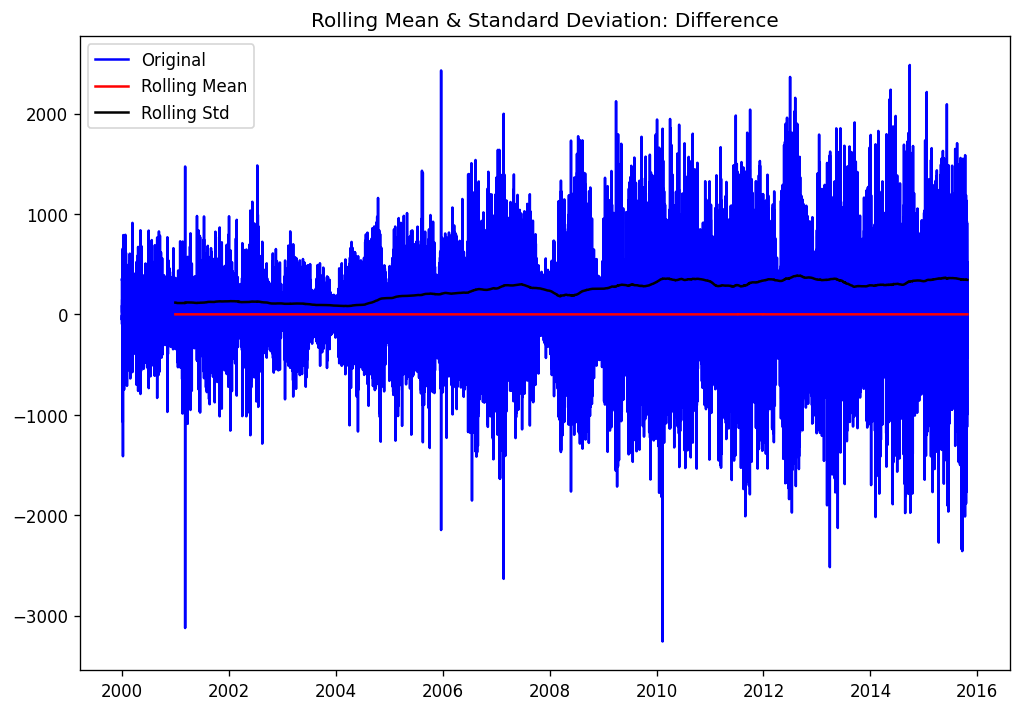

In [117]:
rolling_mean(ts_diff_train, "Difference")

### Teste de Estacionariedade 

In [118]:
ADF_test(ts_diff_train)

Results of Dickey-Fuller Test:
ADF Statistic: -57.4816080838378
p-value: 0.0
Critial Values:
   1%, -3.4303972122877826
Critial Values:
   5%, -2.861560867155461
Critial Values:
   10%, -2.566781106845521


In [119]:
KPSS(ts_diff_train)


Results of KPSS Test:
KPSS Statistic: 0.003570
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), Int

In [120]:
def persistence_one_step_diff(ts_diff_train, ts_diff_test, 
                              test, show_results=False, plot_result=False):

    # Prepare data
    ts_diff_test = ts_diff_test.values
    ts_diff_train = [x for x in ts_diff_train]

    # Walk-forward validation
    predictions = list()

    for i in range(len(ts_diff_test)):
        # Predict
        yhat = ts_diff_train[-1]
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to train for the next loop
        obs = ts_diff_test[i]
        ts_diff_train.append(obs)
        
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


    # Report performance
    mape = mean_absolute_percentage_error(test, invert_difference(test, predictions))
    print('MAPE: %.3f' % mape)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(test)
        plt.plot(invert_difference(test, predictions), color='red')
        plt.show()

In [121]:
persistence_one_step_diff(ts_diff_train, ts_diff_test, test)

MAPE: 0.052


In [126]:
def invert_diff_predicions(test, forecasts, n_steps):
    output = list()
    for i in range (len(forecasts)+1):
        output.append(np.zeros(n_steps))


    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[:len(ypred_ts)+1]
        ypred_ts = invert_difference(ytrue_ts,ypred_ts)

        for j in range(len(ypred_ts)):
            output[j][i] = ypred_ts[j]

    return output


In [127]:
def plot_forecasts_diff(series, forecasts, test):
    # Plot the entire dataset in blue
    plt.plot(series)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
        yaxis = forecasts[i]  
        yaxis = np.insert(yaxis,0,[series[off_s]])

        #print(len(forecasts[i]))
        #print((yaxis))
        #break

        plt.plot(xaxis, yaxis, color='red')

    # Show the final plot
    plt.show()  

In [128]:
def persistence_multi_step_diff(train,test, train_orig, test_orig, steps=24, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([train_orig, test_orig], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train = [x for x in train]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train[-1]
        yhat = persistence(last_ob, n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
    # Evaluate the 
    evaluate_forecasts_diff(test_orig, forecasts, n_steps)
    # Plot the forecasts
    if plot_result:
        forecasts = invert_diff_predicions(test_orig, forecasts, n_steps)
        plot_forecasts_diff(series, forecasts, test_orig)


In [129]:
# Evaluate the MAPE for each forecast time step
def evaluate_forecasts_diff(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i+1]
        ypred_ts = invert_difference(ytrue_ts,ypred_ts)
        print('t+%d MAPE: %f' % ((i+1), (mean_absolute_percentage_error(ytrue_ts, ypred_ts))))



In [130]:
persistence_multi_step(ts_diff_train, ts_diff_test, train, test, steps=24, 
    plot_result=False)

t+1 MAPE: 0.051873
t+2 MAPE: 0.067937
t+3 MAPE: 0.071422
t+4 MAPE: 0.074003
t+5 MAPE: 0.075890
t+6 MAPE: 0.077860
t+7 MAPE: 0.079213
t+8 MAPE: 0.080229
t+9 MAPE: 0.081080
t+10 MAPE: 0.081273
t+11 MAPE: 0.081468
t+12 MAPE: 0.081642
t+13 MAPE: 0.080926
t+14 MAPE: 0.080602
t+15 MAPE: 0.080966
t+16 MAPE: 0.080432
t+17 MAPE: 0.079580
t+18 MAPE: 0.078292
t+19 MAPE: 0.075927
t+20 MAPE: 0.073807
t+21 MAPE: 0.071639
t+22 MAPE: 0.068904
t+23 MAPE: 0.061093
t+24 MAPE: 0.052053
